In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pickle
import ast
import re

In [74]:
df = pd.read_csv('dataset/train.csv')

In [75]:
df

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0109403,en,Chasers,Military men Rock Reilly and Eddie Devane are ...,9.853270,...,4/22/94,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was supposed to be a routine prisoner trans...,Chasers,"[{'id': 378, 'name': 'prison'}, {'id': 572, 'n...","[{'cast_id': 2, 'character': 'Rock Reilly', 'c...","[{'credit_id': '52fe4494c3a368484e02ac7d', 'de...",1596687
2996,2997,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,tt2364975,sv,Vi är bäst!,Three girls in 1980s Stockholm decide to form ...,3.727996,...,3/28/13,102.0,"[{'iso_639_1': 'sv', 'name': 'svenska'}]",Released,NaN,We Are the Best!,"[{'id': 1192, 'name': 'sweden'}, {'id': 4470, ...","[{'cast_id': 5, 'character': 'Bobo', 'credit_i...","[{'credit_id': '5716b72ac3a3686678012c84', 'de...",180590
2997,2998,NaN,65000000,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",NaN,tt0116908,en,The Long Kiss Goodnight,"Samantha Caine, suburban homemaker, is the ide...",14.482345,...,10/11/96,120.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What's forgotten is not always gone.,The Long Kiss Goodnight,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 10, 'character': 'Samantha Caine ...","[{'credit_id': '52fe443a9251416c7502d579', 'de...",89456761
2998,2999,NaN,42000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",http://www

# 1:Data Preprocessing

# 1.1:drop columns

In [45]:
df.drop(columns=['id', 'homepage', 'imdb_id', 'original_language', 'original_title', 'poster_path', 
                 'tagline', 'overview', 'belongs_to_collection', 'title', 'spoken_languages', 
                 'production_companies', 'production_countries'], inplace=True)

first , we are going to drop columns which we consider not valuable and have less impact on the output data.

In [46]:
df.isnull().sum()

budget            0
genres            7
popularity        0
release_date      0
runtime           2
status            0
Keywords        276
cast             13
crew             16
revenue           0
dtype: int64

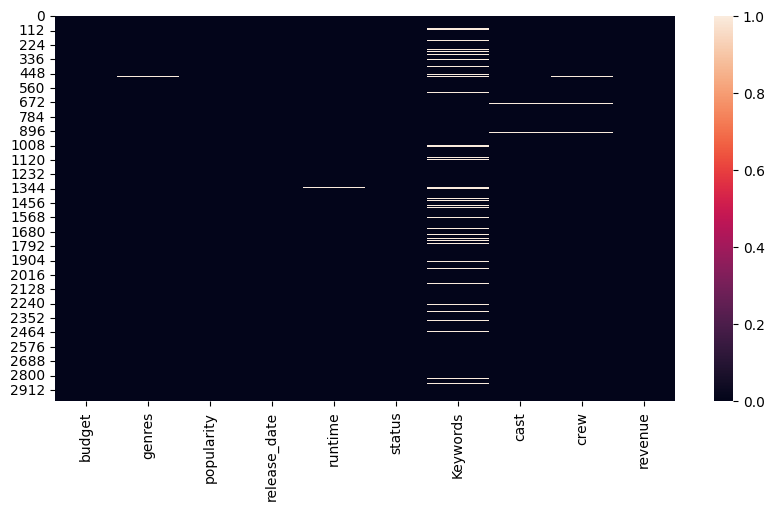

In [47]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull())
plt.show()

then , we found out how many values are missing in the dataset columns and draw the heatmap of the missing values 
in each columns(features)

# 1.2: genres ,keywords ,cast and crew  extraction process.

first , we want to extract or convert list of dic into its actual form if its wrapped in string quotation mark and if it is not wrapped ,we leave it like it is.

In [48]:
cols = ['genres', 'Keywords', 'cast', 'crew']
for col in cols:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# ----------------------------------------------------------------------------------------------------------

now , in the below code , first line extract name of the dictionary items which have job of director ,then 2nd line extract first 3 cast members from the cast column in each row and the 3rd line do the same thing but only for "keywords" column.
and the 4th line extraxts genres name from dictionaries inside the list and if it is not list then converts it into NAN value.
and then crew columns is drop from df .


In [49]:
df['director'] = df['crew'].apply(lambda x: [i['name'] for i in x if isinstance(i, dict) and i['job'] == 'Director'] if isinstance(x, list) else np.nan)
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in x[:3] if isinstance(i, dict)] if isinstance(x, list) else np.nan)
df['Keywords'] = df['Keywords'].apply(lambda x: [i['name'] for i in x[:3] if isinstance(i, dict)] if isinstance(x, list) else np.nan)
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in x if isinstance(i, dict)] if isinstance(x, list) else np.nan)
df.drop(columns=['crew'], inplace=True)

# ---------------------------------------------------------------------------------------------------

first line selects features having object dtype and then loops over on each column in obj_col. the below code then find the mod for column and if there are list or tuple it extract and joing its element with a comma and NAN values is filled wth "unknown" word and if the mod is not list or tuple then NAN value is filled with mod value.finally in the last if no condition is met it simply prints out the below mssge.|

In [50]:
obj_col = df.select_dtypes('object').columns
for col in obj_col:
    mode_values = df[col].mode()
    if not mode_values.empty:
        mode_value = mode_values.iloc[0]
        if isinstance(mode_value, (list, tuple)):
            print(f"Column {col} contains a list/tuple. Converting lists to strings.")
            df[col] = df[col].apply(lambda x: ', '.join(x) if isinstance(x, (list, tuple)) else x)
            df[col] = df[col].fillna('Unknown')
        else:
            df[col] = df[col].fillna(mode_value)
    else:
        print(f"No mode found for column: {col}")

Column genres contains a list/tuple. Converting lists to strings.
Column Keywords contains a list/tuple. Converting lists to strings.
Column cast contains a list/tuple. Converting lists to strings.
Column director contains a list/tuple. Converting lists to strings.


# ----------------------------------------------------------------------------------------------------------

# 1.3: popularity, release_date, runtime and budget conversion

in this code .popularity is converted into float , release_date is converted into date time , runtime and budget into numeric (int or float) . and then rows having NAN values or dropped from runtime and revenue. 

In [51]:
df['popularity'] = df['popularity'].astype(float)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

C:\Users\Hamza Computer\AppData\Local\Temp\ipykernel_8360\550962158.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')


In [52]:
df = df.dropna(subset=['runtime', 'revenue'])

here only year column is taken from to_datetime conversion and the original column is dropp as it serve no purpose .

In [53]:
df['year'] = df['release_date'].dt.year
df.drop(columns='release_date', inplace=True)

below is the visualization of these columns .


C:\Users\Hamza Computer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


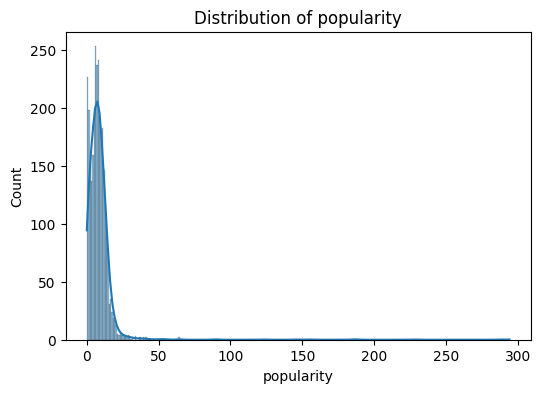

C:\Users\Hamza Computer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


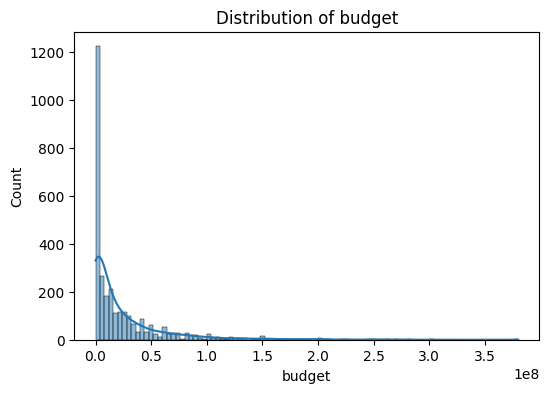

C:\Users\Hamza Computer\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


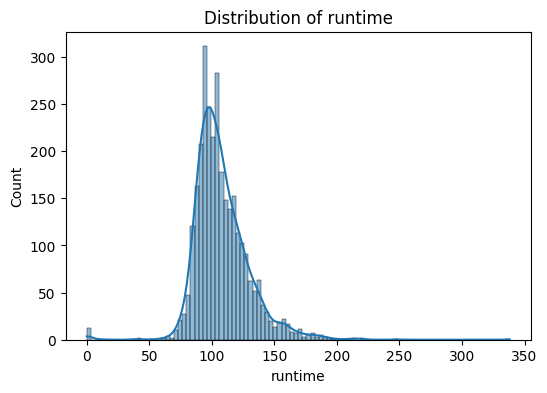

In [54]:
cols = ['popularity','budget','runtime']
for col in cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

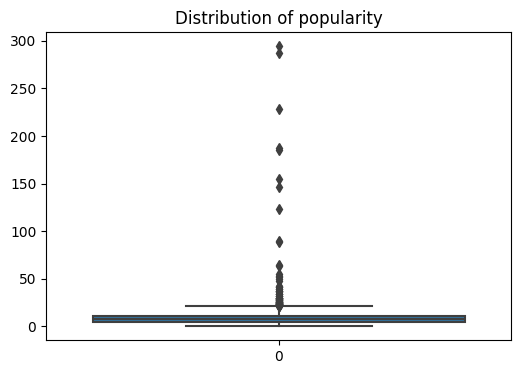

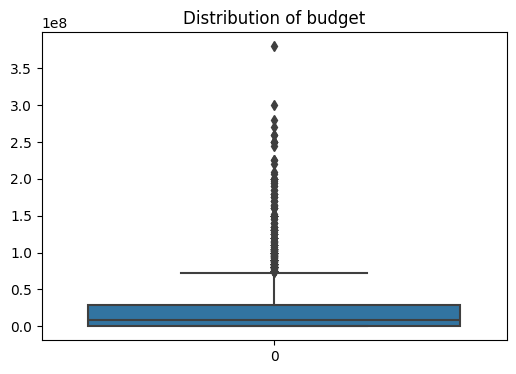

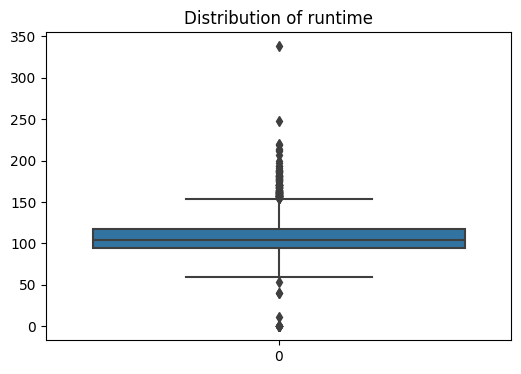

In [55]:
cols = ['popularity','budget','runtime']
for col in cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

Text(0.5, 1.0, 'Budget vs Popularity')

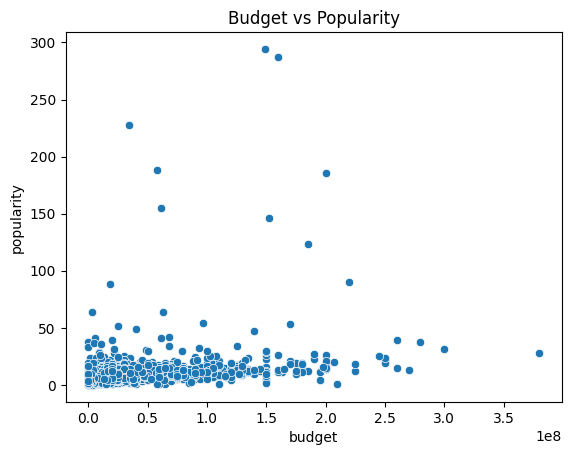

In [56]:
sns.scatterplot(x=df['budget'],y=df['popularity'])
plt.title('Budget vs Popularity')

Text(0.5, 1.0, 'Budget vs Popularity')

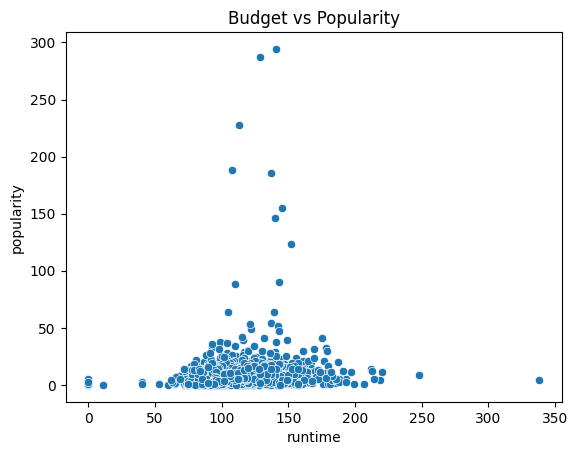

In [57]:
sns.scatterplot(x=df['runtime'],y=df['popularity'])
plt.title('Budget vs Popularity')

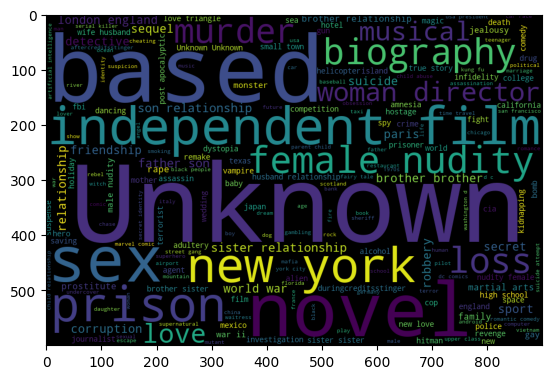

In [58]:
from wordcloud import WordCloud
df['Keywords'] = df['Keywords'].astype(str)
keyword = ' '.join(df['Keywords'])
wc = WordCloud(width=900,height=600).generate(keyword)
plt.imshow(wc)

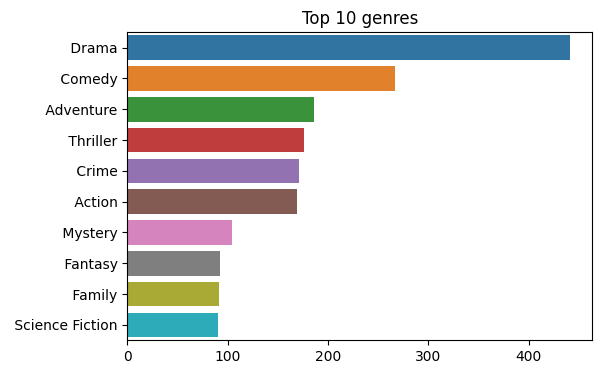

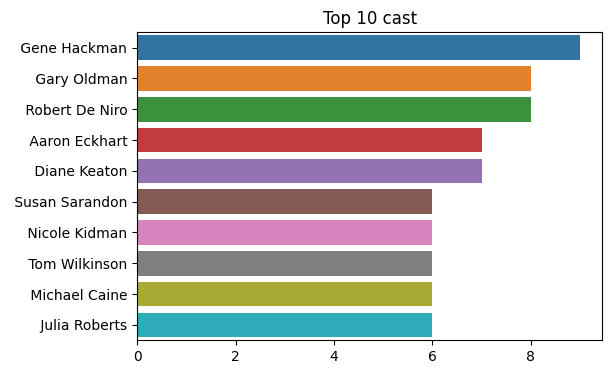

In [59]:
cols = ['genres','cast']
for col in cols:
    plt.figure(figsize=(6,4))
    string = ' '.join(df[col])
    spl =  string.split(',')
    s = pd.Series(spl).value_counts(ascending=False)[:10]
    sns.barplot(x=s.values,y=s.index)
    plt.title(f'Top 10 {col}')
    plt.show()    

Text(0, 0.5, 'movie count')

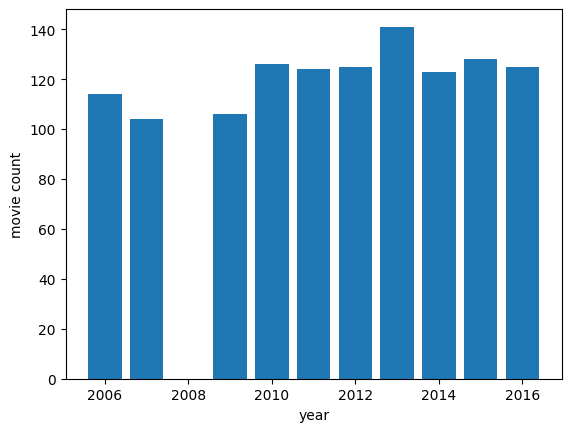

In [60]:
date = df['year'].value_counts()
date = date.iloc[0:10]
plt.bar(x=date.index, height=date.values.flatten())
plt.xlabel('year')
plt.ylabel('movie count')


# -----------------------------------------------------------------------------------------------

# 1.4: genres ,keywords and cast conversion into numerical values.

we created 3 instances for each columns of the class.

In [61]:
mlb_genres = MultiLabelBinarizer()
mlb_keywords = MultiLabelBinarizer()
mlb_cast = MultiLabelBinarizer()

# -----------------------------------------------------------------------------------------------

first line ensure all values are list and then it transform it into one hot encoding and return a new dataframe containing each genre as separate column. and the 2nd and 3rd lines do the same only for keywords and cast columns .

In [62]:
df_genres = pd.DataFrame(mlb_genres.fit_transform(df['genres'].apply(lambda x: x if isinstance(x, list) else [])), columns=mlb_genres.classes_, index=df.index)
df_keywords = pd.DataFrame(mlb_keywords.fit_transform(df['Keywords'].apply(lambda x: x if isinstance(x, list) else [])), columns=mlb_keywords.classes_, index=df.index)
df_cast = pd.DataFrame(mlb_cast.fit_transform(df['cast'].apply(lambda x: x if isinstance(x, list) else [])), columns=mlb_cast.classes_, index=df.index)

# -----------------------------------------------------------------------------------------------

here the new created dataframes are joind or linked to the original df.

In [63]:
df = pd.concat([df, df_genres, df_keywords, df_cast], axis=1)

# -----------------------------------------------------------------------------------------------

an instance is created from the class and then status column is transformed .

In [64]:
le = LabelEncoder()
df['status'] = le.fit_transform(df['status'])

# -----------------------------------------------------------------------------------------------

# 1.5:scaling of budget, runtime , popularity and year.

we then created instance of standardScaler class and transform the below columns using it.

In [65]:
scaler = StandardScaler()
df[['budget', 'runtime', 'popularity', 'year']] = scaler.fit_transform(df[['budget', 'runtime', 'popularity', 'year']])

# -----------------------------------------------------------------------------------------------

# 2: splitting the data into train and test

In [66]:
X = df.drop(columns=['revenue', 'genres', 'Keywords', 'cast', 'director'])
y = np.log1p(df['revenue'])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -----------------------------------------------------------------------------------------------

# 3: training the model.

In [68]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [69]:
pred_for_train=xgb_model.predict(X_train)
pred_for_test=xgb_model.predict(X_test)

# -----------------------------------------------------------------------------------------------

# 3.1: model evaluation.

In [70]:
rmse_for_train=np.sqrt(mean_squared_error(y_train, pred_for_train))
rmse_for_test=np.sqrt(mean_squared_error(y_test,pred_for_test))

print(f"rmse of training :{rmse_for_train}")
print(f"rmse of test :   {rmse_for_test}")

rmse of training :0.7105343147626673
rmse of test :   2.2776971423190333


In [71]:
r2_train = r2_score(y_train, pred_for_train)
r2_test = r2_score(y_test,pred_for_test)
print(r2_train)
print(r2_test)

0.9472865829739717
0.41219808939266667


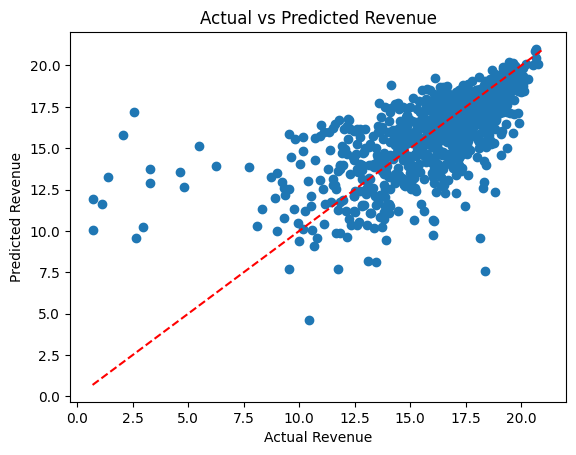

In [72]:
plt.scatter(y_test, pred_for_test)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue")
max_value = max(max(y_test), max(pred_for_test))
min_value = min(min(y_test), min(pred_for_test))  
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

plt.show()

# -----------------------------------------------------------------------------------------------

# 3.2: Hyper-parameter tunning 

In [37]:
param_grid = {
    'learning_rate': [0.01, 0.1,1.0],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 1, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'lambda': [0, 1, 10],
    'alpha': [0, 0.5, 1],
}

In [38]:
GridSearch=GridSearchCV(estimator=xgb_model,param_grid=param_grid,scoring='neg_mean_squared_error',cv=3,verbose=1)

In [ ]:
GridSearch.fit(X_train, y_train)

In [ ]:
print("Best parameters : ", GridSearch.best_params_)

In [ ]:
best_model = GridSearch.best_estimator_

In [ ]:
best_pred = best_model.predict(X_test)

# -----------------------------------------------------------------------------------------------

# 3.3: best_model evaluation

In [ ]:
mse = mean_squared_error(y_test, best_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
rmse_for_train=np.sqrt((mse))
rmse_for_test=np.sqrt(mse)

print(f"rmse of training :{rmse_for_train}")
print(f"rmse of test :   {rmse_for_test}")

In [42]:
r2_train = r2_score(y_train, best_pred)
r2_test = r2_score(y_test,best_pred)
print(r2_train)
print(r2_test)

NameError: name 'best_pred' is not defined

In [ ]:
plt.scatter(y_test, best_pred)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Revenue (Best Model)")
max_value = max(max(y_test), max(best_pred))  
min_value = min(min(y_test), min(best_pred))  
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--')

plt.show()

# -----------------------------------------------------------------------------------------------

# 4: saving the model, scalar and encoders

In [34]:

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
with open('labelencoder.pkl', 'wb') as file:
    pickle.dump(le, file)
with open('mlb_genres.pkl', 'wb') as file:
    pickle.dump(mlb_genres, file)
with open('mlb_keywords.pkl', 'wb') as file:
    pickle.dump(mlb_keywords, file)
with open('mlb_cast.pkl', 'wb') as file:
    pickle.dump(mlb_cast, file)

# -----------------------------------------------------------------------------------------------

# 5.1: function for getting user Input.

In [35]:
def get_user_input():
    user_input = {}
    try:
        user_input['budget'] = float(input("Enter the budget: "))
        user_input['popularity'] = float(input("Enter the popularity: "))
        user_input['runtime'] = float(input("Enter the runtime: "))
        user_input['status'] = input("Enter the status (e.g., 'Released', 'Post Production'): ")
        user_input['year'] = int(input("Enter the release year: "))
        user_input['genres'] = input("Enter genres (comma separated): ").split(',')
        user_input['Keywords'] = input("Enter keywords (comma separated): ").split(',')
        user_input['cast'] = input("Enter cast (comma separated): ").split(',')
    except ValueError as e:
        print(f"Invalid input: {e}")
        return None
    
    return user_input

# -----------------------------------------------------------------------------------------------

# 5.2: function for conversion of user input for prediction .

first we load the saved encoders and scalar ..to transform the data lik exactly the one which trained the model.then we scale , label encode and one hot encode   input data accordingly to the to the data we trained our model.to avoid features mismatching.

In [36]:
def preprocess_input(user_input):
    df_input = pd.DataFrame([user_input])

    with open('pickle files/scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    with open('pickle files/labelencoder.pkl', 'rb') as file:
        le = pickle.load(file)
    with open('pickle files/mlb_genres.pkl', 'rb') as file:
        mlb_genres = pickle.load(file)
    with open('pickle files/mlb_keywords.pkl', 'rb') as file:
        mlb_keywords = pickle.load(file)
    with open('pickle files/mlb_cast.pkl', 'rb') as file:
        mlb_cast = pickle.load(file)

    df_input[['budget', 'runtime', 'popularity', 'year']] = scaler.transform(df_input[['budget', 'runtime', 'popularity', 'year']])
    
    df_input['status'] = le.transform(df_input['status'].astype('str'))

    df_genres = pd.DataFrame(mlb_genres.transform([user_input['genres']]), columns=mlb_genres.classes_)
    df_keywords = pd.DataFrame(mlb_keywords.transform([user_input['Keywords']]), columns=mlb_keywords.classes_)
    df_cast = pd.DataFrame(mlb_cast.transform([user_input['cast']]), columns=mlb_cast.classes_)
    
    df_input = pd.concat([df_input, df_genres, df_keywords, df_cast], axis=1)
    
    # Align with model training columns
    required_columns = X_train.columns
    df_input = df_input.reindex(columns=required_columns, fill_value=0)
    
    return df_input

# -----------------------------------------------------------------------------------------------

# 5.3: function for prediction.

In [39]:
def predict_revenue(user_input):
    with open('pickle files/xgb_model.pkl', 'rb') as file:
        model = pickle.load(file)
    
    processed_input = preprocess_input(user_input)
    predicted_log_revenue = model.predict(processed_input)
    
    # Reverse the log transformation
    predicted_revenue = np.expm1(predicted_log_revenue)[0]
    return predicted_revenue

# 5.4: calling the functions

In [40]:
user_input = get_user_input()
if user_input:
    predicted_revenue = predict_revenue(user_input)
    print(f"Predicted Revenue: ${predicted_revenue:,.2f}")
else:
    print("Invalid input. Please try again.")

Enter the budget: 4000
Enter the popularity: 5
Enter the runtime: 37
Enter the status (e.g., 'Released', 'Post Production'): Released
Enter the release year: 2011
Enter genres (comma separated): Horror
Enter keywords (comma separated): duty
Enter cast (comma separated): brad pitt
Predicted Revenue: $1,092,001.25


C:\Users\Hamza Computer\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['Horror'] will be ignored
  warnings.warn(
C:\Users\Hamza Computer\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['duty'] will be ignored
  warnings.warn(
C:\Users\Hamza Computer\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['brad pitt'] will be ignored
  warnings.warn(
